In [2]:
import reeds
import pygromos

from reeds.function_libs.file_management import file_management as fM
#from reeds.function_libs.analysis import analysis as ana

from pygromos.files.imd import Imd
import numpy as np
import matplotlib.pyplot as plt

import copy

from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr

from scipy.stats import bootstrap

import matplotlib.pyplot as plt
import matplotlib

from my_bootstrap import calculate_statistics_with_errors

/home/cchampion/programs/reeds/reeds/submodules/pygromos/pygromos/files/topology/top.py:20: UserWarning: Module topo-files is under Development and not entirely implemented!
  warnings.warn("Module topo-files is under Development and not entirely implemented!")


In [2]:
def plot_free_energies1(exp, sim, exp_err, labels_sim, title=None, colors=None, markers=None,
                       two_greyed_regions=True, manual_lims=None, figsize=None):
    """
    This function will plot the results in a square scatter plot
    
    """

    fontsize = 24 
    
    active_qualitative_map_mligs = lambda num_ligs: plt.cm.viridis(np.linspace(0,1,num_ligs))
    active_qualitative_map_mligs = lambda num_ligs: plt.cm.cividis(np.linspace(0,1,num_ligs))
    color_blind_frienfly = active_qualitative_map_mligs(8)
    
    if figsize is None:
        figsize = [9,9]
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize =figsize)
    
    def plot_errorbar(ax, x, y, x_err, y_err, color, label, zorder, alpha, marker = 's'):
        markers, caps, bars = ax.errorbar(x, y, y_err, 
                                          x_err,
                                          fmt=marker, markersize = 6,
                                          color = color, mec = 'black',
                                          ecolor = color, label = label,
                                          capthick=1.5, capsize=4, linewidth = 3,
                                          zorder=zorder, alpha = alpha
                                         )
        [bar.set_alpha(1) for bar in bars]
        [cap.set_alpha(1) for cap in caps]

    for i, (s, label) in enumerate(zip(sim, labels_sim)):
        print (label)
        plot_errorbar(axes, exp, s[0], exp_err, s[1], color = colors[i],
                      label = label, zorder = 10, alpha = 1, marker = markers[i])

    leg = axes.legend(loc = 'best', fontsize=fontsize, fancybox=True)
    leg.get_frame().set_edgecolor('black')

    x = np.linspace(-100, 100, 50)

    plt.plot(x, x, color = 'black')
    plt.plot(x, x-4.185, color = 'lightgrey')
    plt.plot(x, x+4.185, color = 'lightgrey')
    #
    plt.fill_between(x, x-4.185, x+4.185, color='lightgrey')

    if two_greyed_regions:
        plt.fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

    if title is not None:
        plt.title(title, fontsize = 18)

    plt.xlabel(r'$\Delta G_{bind}$ - Experimental [kJ/mol]', fontsize = fontsize)
    plt.ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = fontsize)


    axes.set_ylim(manual_lims)
    axes.set_xlim(manual_lims)
    # Formatting
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(1.5)

    axes.tick_params(axis="y",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    axes.tick_params(axis="x",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    
    axes.set_box_aspect(1)
    
    return fig, axes


def plot_free_energies_combined_fig(axes, exp, sim, exp_err, labels_sim, title=None, colors=None, markers=None,
                       two_greyed_regions=True, manual_lims=None, figsize=None,legend_loc='best'):
    """
    This function will plot the results in a square scatter plot
    
    """

    fontsize = 24 
    
    if figsize is None:
        figsize = [9,9]
    
    def plot_errorbar(ax, x, y, x_err, y_err, color, label, zorder, alpha, marker = 's'):
        markers, caps, bars = ax.errorbar(x, y, y_err, 
                                          x_err,
                                          fmt=marker, markersize = 6,
                                          color = color, mec = 'black',
                                          ecolor = color, label = label,
                                          capthick=1.5, capsize=4, linewidth = 3,
                                          zorder=zorder, alpha = alpha
                                         )
        [bar.set_alpha(1) for bar in bars]
        [cap.set_alpha(1) for cap in caps]

    for i, (s, label) in enumerate(zip(sim, labels_sim)):
        print (label)
        plot_errorbar(axes, exp, s[0], exp_err, s[1], color = colors[i],
                      label = label, zorder = 10, alpha = 1, marker = markers[i])

    leg = axes.legend(loc = legend_loc, fontsize=fontsize, fancybox=True)
    leg.get_frame().set_edgecolor('black')

    x = np.linspace(-100, 100, 50)

    axes.plot(x, x, color = 'black')
    axes.plot(x, x-4.185, color = 'lightgrey')
    axes.plot(x, x+4.185, color = 'lightgrey')
    #
    axes.fill_between(x, x-4.185, x+4.185, color='lightgrey')

    if two_greyed_regions:
        axes.fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

    if title is not None:
        axes.set_title(title, fontsize = 18)

    axes.set_xlabel(r'$\Delta G_{bind}$ - Experimental [kJ/mol]', fontsize = fontsize)
    #axes.set_ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = fontsize)


    axes.set_ylim(manual_lims)
    axes.set_xlim(manual_lims)
    # Formatting
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(1.5)

    axes.tick_params(axis="y",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    axes.tick_params(axis="x",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    
    axes.set_box_aspect(1)
    
    return None 


# Load the free energies from files

In [3]:
mol_ids = ['3a', '3a', '3b', '3b', '1', '1', '3o', '3o', 
           '3n', '3n', '3c', '3c', '3j', '3j', '3l', '3l']

In [4]:
ic50s_exp = np.array([0.011, 0.011, 0.043, 0.043, 0.053, 0.053, 0.117, 0.117, 
             0.467, 0.467, 0.893, 0.893, 3.09, 3.09, 5.46, 5.46]) / 1000 # in microM, so divided by 1000 gives M units 

ic50s_err = np.array([0.001, 0.001, 0.005, 0.005, 0.012, 0.012, 0.015, 0.015, 
             0.006, 0.006, 0.001, 0.001, 0.3, 0.3, 0.19, 0.19]) / 1000 


In [5]:
def get_asym_errors(ic50s_exp, ic50s_err):
    kt = 2.479
    dgs_err = np.zeros([2, 16]) # + and - error
    dgs_err = np.zeros([16]) # pretend symmetric as its so close to symmetric on plot
    
    
    dgs_exp = kt * np.log(ic50s_exp)
    
    dgs_err = np.abs(kt * np.log(ic50s_exp - ic50s_err) - dgs_exp)
    #dgs_err[1] = np.abs(dgs_exp - kt * np.log(ic50s_exp + ic50s_err))
    
    return dgs_exp, dgs_err
    

In [6]:
# convert those values to free energies: 
kt = 2.479
dgs_exp, dgs_err = get_asym_errors(ic50s_exp, ic50s_err)

## plot to see what the errors look like 

(-30.0, -10.0)

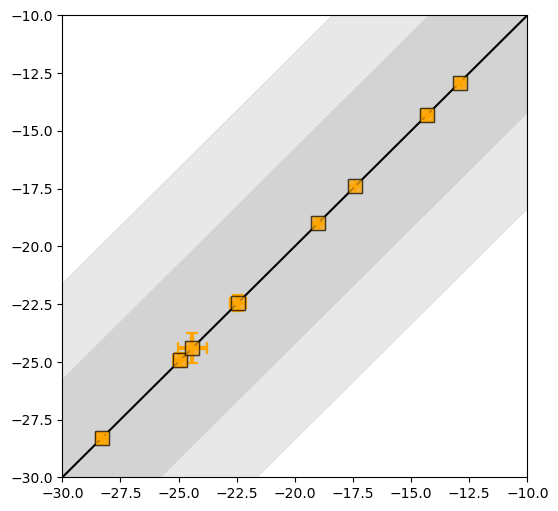

In [7]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize =[6,6])

def plot_errorbar_xy(ax, x, x_err, y, y_err, color, label, zorder, alpha, marker = 's'):
    
    markers, caps, bars = ax.errorbar(x, y, xerr=x_err, yerr = y_err, fmt=marker, markersize = 10,
                                      color = color, mec = 'black',
                                      ecolor = color, label = label,
                                      capthick=1.5, capsize=4, linewidth = 3,
                                      zorder=zorder, alpha = alpha
                                     )
    [bar.set_alpha(1) for bar in bars]
    [cap.set_alpha(1) for cap in caps]

plot_errorbar_xy(axes, dgs_exp, dgs_err, dgs_exp, dgs_err, color = 'orange',
             label = 'exp', zorder = 10, alpha = 0.5, marker = 's')

x = np.linspace(-100, 100, 50)

plt.plot(x, x, color = 'black')
plt.plot(x, x-4.185, color = 'lightgrey')
plt.plot(x, x+4.185, color = 'lightgrey')
#
plt.fill_between(x, x-4.185, x+4.185, color='lightgrey')
plt.fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

axes.set_xlim([-30, -10])
axes.set_ylim([-30, -10])

# The errors are basically very small

# Load the data from simulations 

In [8]:
#path_solv = '/cluster/home/cchampion/work/REEDS/protonation/GSK3b/ligands/'

#tmp = np.array([np.load(f'{path_solv}/g_prod_seed{i}/analysis/free_energy/deltaGs_mbar.npy') for i in range(1, 6)])

#dgs_solv = np.mean(np.array(tmp), axis = 0)
#dgs_solv_err = np.std(np.array(tmp), axis = 0)

In [9]:
basedir = '/fileserver/pine/pine2/cchampion/REEDS/2_protonation/paper_programs/data/GSK3b'

In [10]:
prefix = f'{basedir}/ligands/zwanzig_trim10/'
zwanzig_dgs = np.array([np.load(f'{prefix}/deltaGs_mbar_seed{i}.npy') for i in range(1, 6)])

dgs_solv_sharedR = np.mean(np.array(zwanzig_dgs), axis = 0)
dgs_solv_sharedR_err = np.std(np.array(zwanzig_dgs), axis = 0)

# Load the data from complex sims

In [11]:
prefix = f'{basedir}/complex/zwanzig_trim10/'
zwanzig_dgs = np.array([np.load(f'{prefix}/deltaGs_mbar_seed{i}.npy') for i in range(1, 6)])

dgs_comp_sharedR = np.mean(np.array(zwanzig_dgs), axis = 0)
dgs_comp_sharedR_err = np.std(np.array(zwanzig_dgs), axis = 0)

# Here state 2 is soo poorly sampled in simulation #3 that we discard that data point 

dgs_comp_sharedR[1] = np.mean(zwanzig_dgs.T[1][[0, 1, 3, 4]])
dgs_comp_sharedR_err[1] = np.std(zwanzig_dgs.T[1][[0, 1, 3, 4]])

In [12]:
# to comapre with data when we don't remove first 10% of sim.

#path_complex = '/cluster/home/cchampion/work/REEDS/protonation/GSK3b_sharedR/complex/'

#prefix = '/cluster/home/cchampion/work/REEDS/protonation/GSK3b_sharedR/results/complex/zwanzig/'
#zwanzig_dgs = np.array([np.load(f'{prefix}/deltaGs_mbar_seed{i}.npy') for i in range(1, 6)])

#dgs_comp_sharedR2 = np.mean(np.array(zwanzig_dgs), axis = 0)
#dgs_comp_sharedR2_err = np.std(np.array(zwanzig_dgs), axis = 0)

In [13]:
def offset_comparison(dgs_exp, alch_dg_complex, alch_dg_water):
    """
    This function performs a direct comparison where the simulated delta_G values for 
    all states are calculated and offset by following the procedure described in:
    
    in eq. 2 of https://pubs.acs.org/doi/10.1021/acs.jctc.6b01141
     
    Here this hence returns N data points corresponding to dGs
    
    The error bars for state 1 are calculated as the average of all other errors. 
    
    
    Args
    -----
        ic50s:
            list of ic50s
        alch_dg_complex:
            list of alchemical deltaGs (1->1, 1->2, ..., 1->N) (average and standard deviations) in complex
        alch_dg_water
            list of alchemical deltaGs (1->1, 1->2, ..., 1->N) (average and standard deviations) in water
    
    Returns
    -------
        ddgs_exp, ddgs_sim
    """
    # Simulated vales
    ddgs_binding = alch_dg_complex - alch_dg_water
   
    # Offsetting all data points 
    n = len(ddgs_binding)
    dgs_binding = ddgs_binding - (np.sum(ddgs_binding) / n - np.sum(dgs_exp) / n )
   
    return dgs_binding

def realign_with_exp(dgs_exp, dgs_sim):
    # Offsetting all data points 
    n = len(dgs_sim)
    return dgs_sim - (np.sum(dgs_sim) / n - np.sum(dgs_exp) / n )

In [14]:
# test_dg_sharedR
dgs_bind_all = offset_comparison(dgs_exp, dgs_comp_sharedR, dgs_solv_sharedR)

dgs_bind_err_all = np.sqrt(np.power(dgs_comp_sharedR_err, 2) + np.power(dgs_solv_sharedR_err, 2))

# Get error by simply propagating them
dgs_binding_all = np.array([dgs_bind_all, dgs_bind_err_all])

In [15]:
dgs_binding_tautA = np.array([realign_with_exp(dgs_exp[::2], dgs_bind_all[::2]), dgs_bind_err_all[::2]])

In [16]:
dgs_binding_tautB = np.array([realign_with_exp(dgs_exp[1::2], dgs_bind_all[1::2]), dgs_bind_err_all[1::2]])

In [17]:

from my_bootstrap import get_rel_ddGs

In [18]:
get_rel_ddGs(dgs_exp[::2])

array([ 3.37963271,  3.89797127,  5.8610468 ,  9.29236785, 10.89939775,
       13.97667909, 15.38791851,  0.51833857,  2.4814141 ,  5.91273514,
        7.51976505, 10.59704638, 12.0082858 ,  1.96307553,  5.39439658,
        7.00142648, 10.07870782, 11.48994723,  3.43132105,  5.03835095,
        8.11563229,  9.5268717 ,  1.6070299 ,  4.68431124,  6.09555066,
        3.07728134,  4.48852075,  1.41123942])

In [19]:
calculate_statistics_with_errors(dgs_exp[::2], dgs_binding_tautA[0], dgs_binding_tautA[1], output=True)

RMSE: rmse=(9.255660610674417, 7.8687324535553875, 11.770074520582417)
MAE: mae=(5.304772142372901, 4.3456123158447095, 6.867140438268519)
Spearman: spearman=(0.880952380952381, 0.7380952380952381, 0.9285714285714287)
Kendall: kendall=(0.7857142857142856, 0.6428571428571428, 0.8571428571428571)


((9.26, 7.87, 11.77),
 (5.3, 4.35, 6.87),
 (0.88, 0.74, 0.93),
 (0.79, 0.64, 0.86))

In [20]:
calculate_statistics_with_errors(dgs_exp[::2], dgs_binding_tautB[0], dgs_binding_tautB[1], output=True)

RMSE: rmse=(6.814423219235524, 5.708064714439536, 9.564896987449332)
MAE: mae=(4.206227025556545, 3.30652896868007, 5.582129754911572)
Spearman: spearman=(0.880952380952381, 0.7619047619047621, 0.9285714285714287)
Kendall: kendall=(0.7857142857142856, 0.5714285714285714, 0.8571428571428571)


((6.81, 5.71, 9.56),
 (4.21, 3.31, 5.58),
 (0.88, 0.76, 0.93),
 (0.79, 0.57, 0.86))

In [22]:
# test null model (predict average value)
calculate_statistics_with_errors(dgs_exp[::2], np.ones(8) * np.average(dgs_exp[::2]), np.zeros(8), output=True)

RMSE: rmse=(7.688868309727871, 7.688868309727871, 7.688868309727871)
MAE: mae=(4.5522140518736, 4.5522140518736, 4.5522140518736)
Spearman: spearman=(nan, nan, nan)
Kendall: kendall=(nan, nan, nan)


/localhome/cchampion/.conda/envs/re-eds/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/localhome/cchampion/.conda/envs/re-eds/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


((7.69, 7.69, 7.69), (4.55, 4.55, 4.55), (nan, nan, nan), (nan, nan, nan))

In [23]:
"""
fig, axes = plot_free_energies1(dgs_exp[::2], 
                                [dgs_binding_tautA, dgs_binding_tautB],
                                dgs_err[::2],
                                labels_sim = ['taut A' , 'taut B'],
                                markers = ['o', 'o'],
                                colors = ['#BB1177', '#3388CC'],
                                manual_lims = [-45, 0],
                               #title='Simulation with all 16 states'
                               )
"""
#fig.set_figheight(7)
#fig.set_figwidth(7)
pass
#fig.savefig('/home/cchampion/Desktop/test1.png', dpi=300)

# Combine tautomers into single free energy

In [24]:
def combine_tautomers(dg_tautomer1, dg_tautomer2, t2_t1):
    """
    Testing a function where we assume there is only two tautomers
    with fraction t2_t1 = [T_2] / [T_1]
    """       
    RT = 2.479 #kj/mol at 298.15
    ddgs_lig = dg_tautomer2 - dg_tautomer1
    
    corr_comp = - RT * np.log((np.exp(-ddgs_lig/RT) * t2_t1) + 1)
    corr_solv = + RT * np.log(t2_t1 + 1)
    dgs_corr = dg_tautomer1 + corr_comp + corr_solv
    
    return dgs_corr

In [25]:
mol_ids[::2]

['3a', '3b', '1', '3o', '3n', '3c', '3j', '3l']

In [3]:
# Micro pKa is a list of tuple of micro pKa with [(pka_tautomerA, pka_tautomerB), ..., ]

micro_pka_pairs = [(4.0, 3.3), 
                   (4.3, 3.6), 
                   (4.2, 3.3), 
                   (4.3, 3.4),
                   #
                   (4.3, 3.1),
                   (4.9, 4.0), 
                   (4.4, 4.4), 
                   (4.8, 3.8), 
                  ]

micro_pkas = np.array(micro_pka_pairs)

In [7]:
for i, r in enumerate(micro_pkas):
    print (f'{9+i}  & {r[0]} & {r[1]} \\\\')

9  & 4.0 & 3.3 \\
10  & 4.3 & 3.6 \\
11  & 4.2 & 3.3 \\
12  & 4.3 & 3.4 \\
13  & 4.3 & 3.1 \\
14  & 4.9 & 4.0 \\
15  & 4.4 & 4.4 \\
16  & 4.8 & 3.8 \\


In [27]:
pH = 7.4
frac_BA = np.power(10, np.array(micro_pkas.T[1]) - pH) / np.power(10, np.array(micro_pkas.T[0]) - pH)

# fractions here are defined as [B] / [A] and in this case indicate that tautomer A is more prevalent for all
# molecules (in solution)

frac_BA_comp = frac_BA * np.exp( (dgs_binding_tautA[0] - dgs_binding_tautB[0])/ (kt))

In [28]:
def combine_with_tautomer_corr(dgs_tautomerA, frac_BA, frac_BA_comp):
    """
    
    frac_BA = list of [B]/[A] in solution calculated from micro_pkas
    
    frac_BA_comp = list of [B]/[A] in solution calculated from micro_pkas and adjusted for complex
    
    """
    RT = 2.479 #kj/mol
    dG_corr = - RT * np.log ( (frac_BA_comp + 1) / (frac_BA + 1) )    
    return dgs_tautomerA + dG_corr

In [29]:
dgs_combined = np.zeros([2, 8])
dgs_combined[0] = combine_with_tautomer_corr(dgs_binding_tautA[0], frac_BA, frac_BA_comp)
dgs_combined[1] = np.sqrt(np.power(dgs_binding_tautA[1], 2) + np.power(dgs_binding_tautB[1], 2)) 


In [30]:
calculate_statistics_with_errors(dgs_exp[::2], dgs_combined[0], dgs_combined[1], output=True)

RMSE: rmse=(8.97639053721212, 6.544262284820412, 13.427569828611583)
MAE: mae=(5.173298406858055, 3.700388383780704, 7.234545102263014)
Spearman: spearman=(0.880952380952381, 0.7142857142857144, 0.9285714285714287)
Kendall: kendall=(0.7857142857142856, 0.5714285714285714, 0.8571428571428571)


((8.98, 6.54, 13.43),
 (5.17, 3.7, 7.23),
 (0.88, 0.71, 0.93),
 (0.79, 0.57, 0.86))

In [30]:
"""
fig, axes = plot_free_energies1(dgs_exp[::2], 
                                [dgs_combined],
                                dgs_err[::2],
                                labels_sim = ['combined'],
                                markers = ['o'],
                                colors = ['#04E762'],
                                manual_lims = [-45, 0],
                               #title='Combining the tautomers together'
                                figsize=[12, 8]
                               )
"""
# fig.savefig('/home/cchampion/Desktop/test2.png', dpi=300)
pass

# Make a combined figure with all of the data

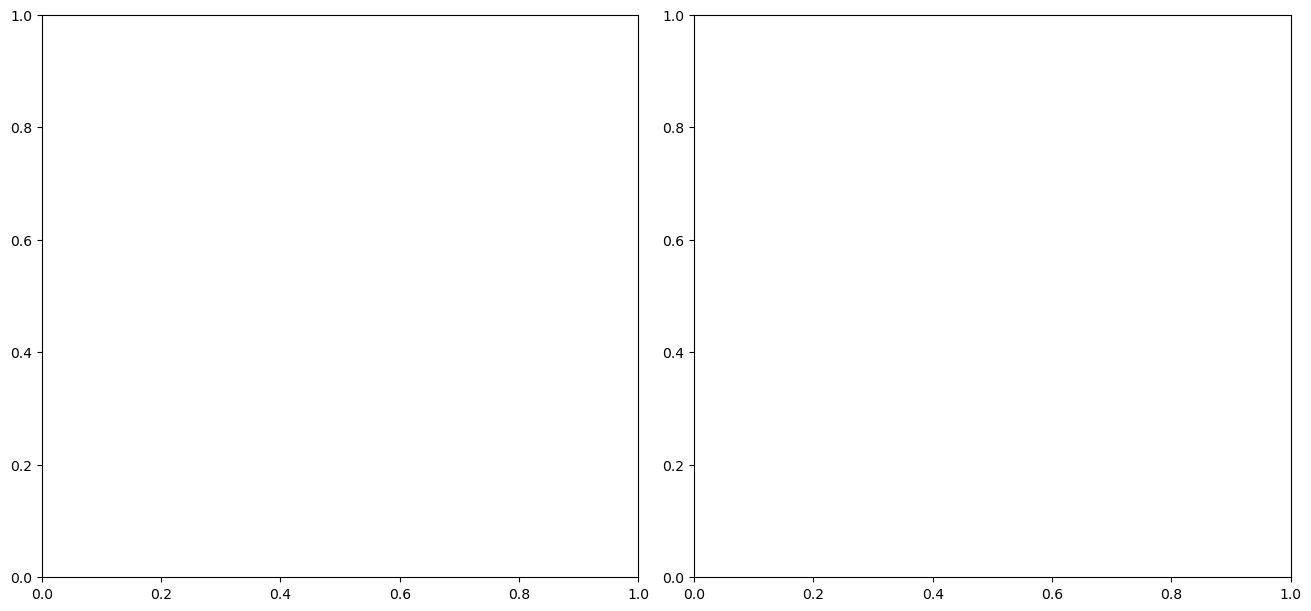

In [99]:
mosaic = """
    AB
    """

def identify_axes(ax_dict, fontsize=48):
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)


fig = plt.figure(layout="constrained", figsize = [13, 6])
ax_dict = fig.subplot_mosaic(mosaic)
#| identify_axes(ax_dict)


In [100]:
plot_free_energies_combined_fig(ax_dict['A'], dgs_exp[::2], 
                                [dgs_binding_tautA, dgs_binding_tautB],
                                dgs_err[::2],
                                labels_sim = ['tautomer A' , 'tautomer B'],
                                markers = ['o', 'o'],
                                colors = ['#BB1177', '#3388CC'],
                                manual_lims = [-45, 0],
                               #title='Simulation with all 16 states'
                                legend_loc = 'lower right'
                               )

ax_dict['A'].set_ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = 24)

ax_dict['A'].text(-42.5, -5.5, 'A',fontsize=36, fontweight='bold')
ax_dict['B'].text(-42.5, -5.5, 'B',fontsize=36, fontweight='bold')

tautomer A
tautomer B


Text(-42.5, -5.5, 'B')

In [101]:
plot_free_energies_combined_fig(ax_dict['B'], dgs_exp[::2], 
                                [dgs_combined],
                                dgs_err[::2],
                                labels_sim = ['combined'],
                                markers = ['o'],
                                colors = ['#0CCE6B'], # BFACC8 or the green: 04E762
                                manual_lims = [-45, 0],
                                legend_loc = 'lower right'
                               #title='Combining the tautomers together'
                               )

for i in range(1, 9):
    ax_dict['B'].text(dgs_exp[2*(i-1)] + 1, dgs_combined[0][i-1] - 2.5, f'({i+8})', fontsize=12, fontweight='bold')

combined


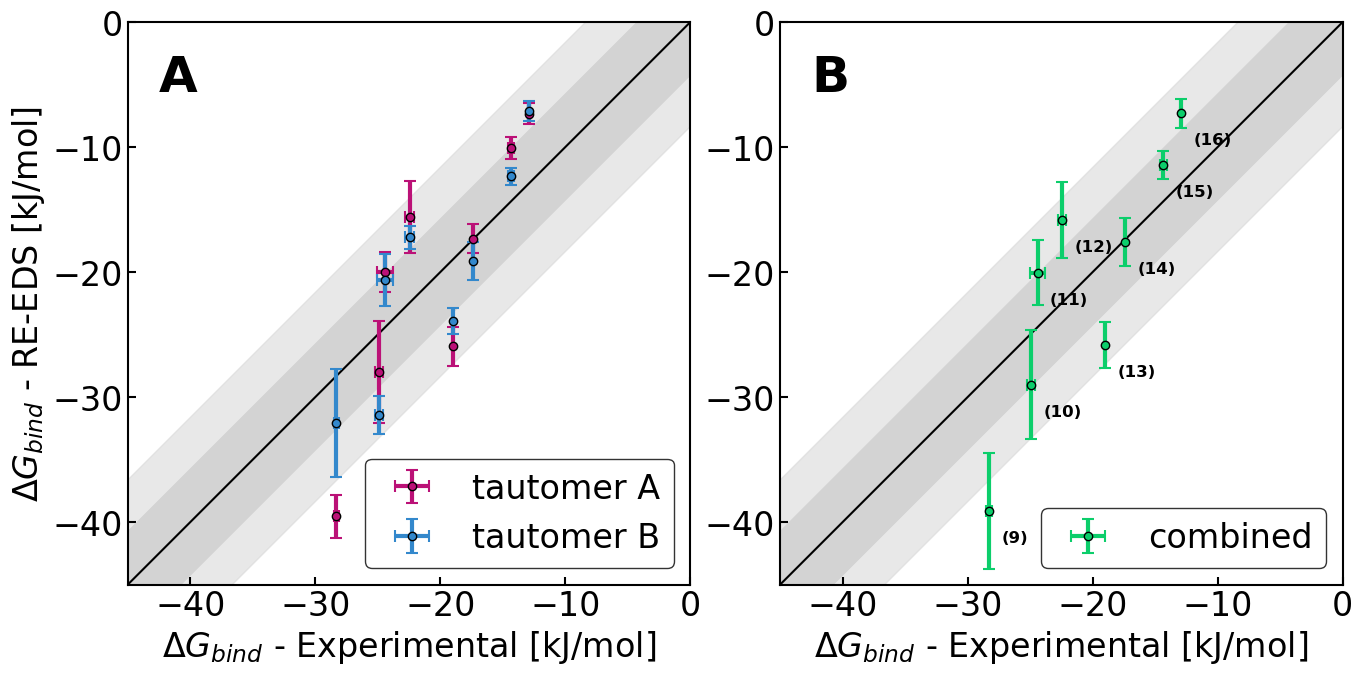

In [102]:
fig

In [103]:
fig.savefig('/home/cchampion/Desktop/test3.png', bbox_inches='tight', dpi=300)
fig.savefig('/home/cchampion/Desktop/GSK3b_free_energies_labeled.pdf', bbox_inches='tight', dpi=300)

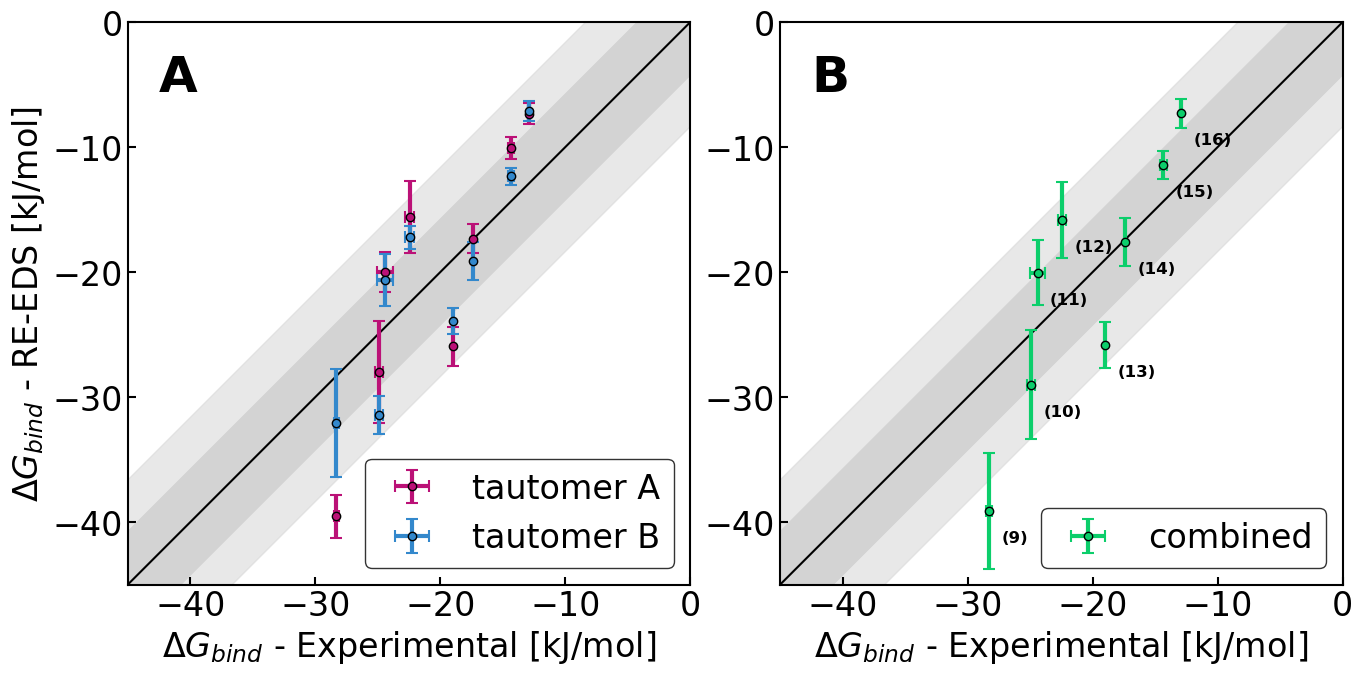

In [104]:
fig